# Generating new images with COSDD

The VAE has learnt to model clean images with its latent variables and the AR decoder has learnt to model the noise generation process. This means we can generate new clean and noisy images.

In [1]:
import os

import tifffile
import torch
import matplotlib.pyplot as plt
import numpy as np

import utils
from dvlae import DVLAE

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load trained model and clean and noisy data

In [3]:
# Go into the folder and stack all of the tiffs into one pytorch tensor
data_dir = "./data/Fluo-C3DH-A549/01"
files = os.listdir(data_dir)
images = [f for f in files if f.endswith(".tif")]
images.sort()
low_snr = [tifffile.imread(os.path.join(data_dir, f)) for f in images]
low_snr = np.stack(low_snr).astype(float)[:, np.newaxis]  # Add channel dimension
low_snr = torch.tensor(low_snr, dtype=torch.float32)

print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([30, 1, 29, 300, 350])


Make sure `model_name` is set to the name used in the training notebook.

In [4]:
model_name = "Fluo-C3DH-A549"
checkpoint_path = os.path.join("checkpoints", model_name)

dvlae = DVLAE.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt")).to(device)

/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'ar_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ar_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 's_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['s_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'direct_d

## 2. Generating new noise for a real noisy image

First, we'll pass a noisy image to the VAE and generate a random sample from the AR decoder. This will give us another noisy image with the same underlying clean signal but a different random sample of noise.

In [5]:
time_idx = 0
inp_image = low_snr[time_idx:time_idx + 1].to(device)
reconstructions = dvlae.reconstruct(inp_image)
denoised = reconstructions["s_hat"].cpu()
noisy = reconstructions["x_hat"].cpu()

100%|██████████|


In [6]:
vmin = np.percentile(low_snr.numpy(), 1)
vmax = np.percentile(low_snr.numpy(), 99)

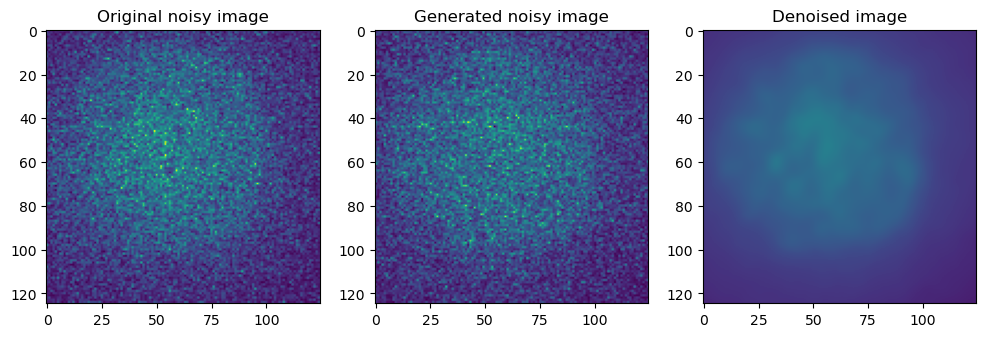

In [7]:
####### C  Z   Y                X #######
crop = (0, 10, slice(100, 225), slice(100, 225))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[time_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Original noisy image")
ax[1].imshow(noisy[0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Generated noisy image")
ax[2].imshow(denoised[0][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("Denoised image")

plt.show()

The spatial correlation of the generated noise can be compared to that of the real noise to get an idea of how accurate the model is. Since we have the denoised version of the generated image, we can get a noise sample by just subtracting it from the generated noisy image.

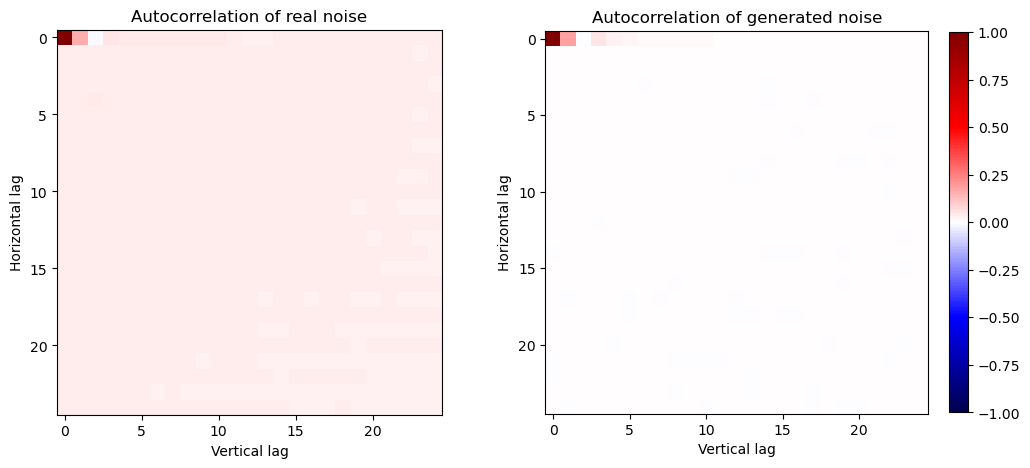

In [8]:
real_noise = low_snr[:, 0, 0]
generated_noise = noisy[0] - denoised[0]

real_ac = utils.autocorrelation(real_noise, max_lag=25)
generated_ac = utils.autocorrelation(generated_noise, max_lag=25)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ac1 = ax[0].imshow(real_ac, cmap="seismic", vmin=-1, vmax=1)
ax[0].set_title("Autocorrelation of real noise")
ax[0].set_xlabel("Vertical lag")
ax[0].set_ylabel("Horizontal lag")
ac2 = ax[1].imshow(generated_ac, cmap="seismic", vmin=-1, vmax=1)
ax[1].set_title("Autocorrelation of generated noise")
ax[1].set_xlabel("Vertical lag")
ax[1].set_ylabel("Horizontal lag")

fig.colorbar(ac2, fraction=0.045)
plt.show()

## 3. Generating new images

This time, we'll generate a sample from the VAE's prior and use the two decoders to reveal a new clean image and its noisy version.

In [9]:
n_imgs = 10
reconstructions = dvlae.sample_prior(n_imgs=n_imgs)
denoised = reconstructions["s"].cpu()
noisy = reconstructions["x"].cpu()

100%|██████████|


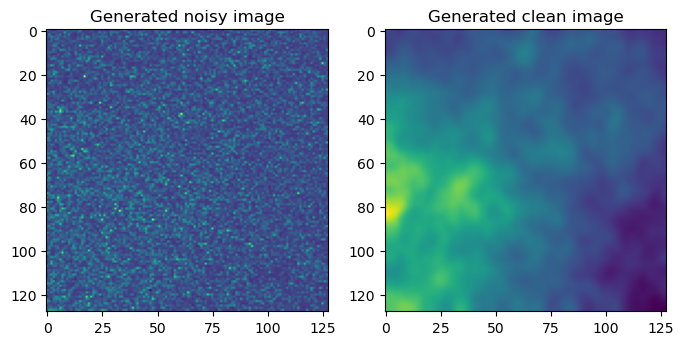

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(noisy[0, 0, 10])
ax[0].set_title("Generated noisy image")
ax[1].imshow(denoised[0, 0, 10])
ax[1].set_title("Generated clean image")

plt.show()